Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [2]:
import sys

assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Create dataset

In [14]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from scipy.io import loadmat

import tensorflow_datasets.public_api as tfds
import toml
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path = Path("../data/raw/emnist")

In [5]:
!cat {path/"metadata.toml"}

filename = 'matlab.zip'
sha256 = 'e1fa805cdeae699a52da0b77c2db17f6feb77eed125f9b45c022e7990444df95'
url = 'https://s3-us-west-2.amazonaws.com/fsdl-public-assets/matlab.zip'


In [6]:
with open("../src/datasets/emnist_essentials.json") as json_file:  
    mapping = json.load(json_file)["mapping"]
    mapping = {m[0]: m[1] for m in mapping}
    
print(f"Number of classes: {len(mapping)}")

Number of classes: 62


In [7]:
metadata = toml.load(path/"metadata.toml")
_URL = metadata["url"]
_DESCRIPTION = "The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19" \
               "and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset."
_IMAGE_SIZE = 28
_IMAGE_SHAPE = (_IMAGE_SIZE, _IMAGE_SIZE, 1)
_NUMBER_OF_CLASSES = len(mapping)

In [8]:
# TODO :: Write tests for this dataset, check out this example https://www.tensorflow.org/datasets/add_dataset#testing_mydataset
class EmnistDataset(tfds.core.GeneratorBasedBuilder):
    """
    "The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19
    and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset."
    From https://www.nist.gov/itl/iad/image-group/emnist-dataset

    The data split we will use is
    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
    """

    VERSION = tfds.core.Version('1.0.0')

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=(_DESCRIPTION),
            features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(shape=_IMAGE_SHAPE),
                "label": tfds.features.ClassLabel(num_classes=_NUMBER_OF_CLASSES),
                "class_name": tfds.features.Text(),
            }),
            # If there's a common (input, target) tuple from the features,
            # specify them here. They'll be used if as_supervised=True in
            # builder.as_dataset.
            supervised_keys=("image", "label"),
            urls=["https://www.nist.gov/itl/iad/image-group/emnist-dataset"],
            citation="Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373",
        )

    def _split_generators(self, dl_manager):
        extracted_path = dl_manager.download_and_extract(_URL)
        data = loadmat(extracted_path/"emnist-byclass.mat")
            
        # Load training dataset
        x_train = data["dataset"][0][0][0][0][0][0]
        x_train = x_train.astype(np.float32)
        y_train = data["dataset"][0][0][0][0][0][1]
            
        # Load test dataset
        x_test = data["dataset"][0][0][1][0][0][0]
        x_test = x_test.astype(np.float32)
        y_test = data["dataset"][0][0][1][0][0][1]
            
        # Reshape using matlab order
        x_train = x_train.reshape(-1, 28, 28, order="A")
        x_test = x_test.reshape(-1, 28, 28, order="A")
        
        # Balance the data
        x_train, y_train = _sample_to_balance(x_train, y_train)
        x_test, y_test = _sample_to_balance(x_test, y_test)
        
        return [
            tfds.core.SplitGenerator(
                name=tfds.Split.TRAIN,
                num_shards=10,
                gen_kwargs={
                    "x": x_train,
                    "y": y_train,
                },
            ),
            tfds.core.SplitGenerator(
                name=tfds.Split.TEST,
                num_shards=1,
                gen_kwargs={
                    "x": x_test,
                    "y": y_test,
                },
            ),
        ]

    def _generate_examples(self, x, y):
        for xi, yi in zip(x, y):
            yield {
                "image": xi,
                "label": yi,
                "class_name": mapping[yi.numpy()],
            }
            
    def _sample_to_balance(self, x, y):
        """Because the dataset is not balanced, we take at most the mean number of instances per class."""
        num_to_sample = int(np.bincount(y.flatten()).mean())

        all_sampled_inds = []
        for label in np.unique(y.flatten()):
            inds = np.where(y == label)[0]
            sampled_inds = np.unique(np.random.choice(inds, num_to_sample))
            all_sampled_inds.append(sampled_inds)

        ind = np.concatenate(all_sampled_inds)
        x_sampled = x[ind]
        y_sampled = y[ind]

        return x_sampled, y_sampled

# Try dataset

In [96]:
train_ds, train_info = tfds.load(name="emnist", split=tfds.Split.TRAIN, with_info=True)

In [97]:
print(train_info)

tfds.core.DatasetInfo(
    name='emnist',
    version=1.0.1,
    description='The EMNIST dataset is a set of handwritten character digitsderived from the NIST Special Database 19 and converted toa 28x28 pixel image format and dataset structure that directlymatches the MNIST dataset.',
    urls=['https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62)
    },
    total_num_examples=814255,
    splits={
        'test': <tfds.core.SplitInfo num_examples=116323>,
        'train': <tfds.core.SplitInfo num_examples=697932>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @article{cohen_afshar_tapson_schaik_2017, 
            title={EMNIST: Extending MNIST to handwritten letters}, 
            DOI={10.1109/ijcnn.2017.7966217}, 
            journal={2017 International Joint Conference on Neural Networks (IJCNN)

In [98]:
print(f"features: {train_info.features}")
print(f"num_classes: {train_info.features['label'].num_classes}")
print(f"names: {train_info.features['label'].names}")
# print(f"class_name: {train_info.features['class_name']}")

features: FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62)})
num_classes: 62
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


# Check one image to make sure it looks fine

Text(0.5, 1.0, 'label: Y')

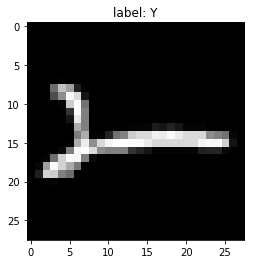

In [99]:
emnist_example, = train_ds.take(1)
image, label = emnist_example["image"], emnist_example["label"]

plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
plt.title(f"label: {mapping[emnist_example['label'].numpy()]}")

# Shuffle and batch the data

In [100]:
train_ds = train_ds.shuffle(1024).batch(32)

# Check the images again

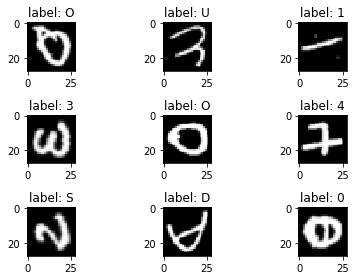

In [105]:
first_batch, = train_ds.take(1)

for i in range(9):
    image, label = first_batch["image"][i], first_batch["label"][i]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
    plt.title(f"label: {mapping[label.numpy()]}")
plt.tight_layout()